In [13]:
%%capture
import numpy as np
from functools import reduce
import time
%run commute.ipynb
%run diagonalize.ipynb
%run phase.ipynb
%run QDrift.ipynb
%run hamiltonian.ipynb

In [14]:
def Simulation_cost(Chs, CPs):
    """ Returns the cost of the simulation,
    total costs, individual costs in [crzs, toffolis]
    """
    crzs, Toffolis = 0, 0
    icosts = []
    n = len(CPs[0][0])
    for Ch, CP in zip(Chs, CPs):
        _, CZ, _ = diag_results(CP, True)
        _, _, cost = logic_min(CZ, Ch)
        crzs += cost[0]
        Toffolis += cost[1]
        icosts.append([cost[0], cost[1]])
    tcost = [crzs, Toffolis]
    return np.array(tcost), np.array(icosts)

def Hs_sum(CHs, Chs):
    """ Regroups the cliques according to coefficients
    """
    tolerance = 1e-3
    SHs, Shs = [], []
    for CH, Ch in zip(CHs, Chs):
        SH, Sh = [], []
        idx = np.argsort(Ch)
        sCH, sCh = np.array(CH)[idx][::-1], np.array(Ch)[idx][::-1]
        while len(sCh) > 0:
            if np.abs(sCh[0]) < tolerance:
                break
            Sh.append(sCh[0])
            SH.append(np.sum(sCH, axis=0))
            sCh = sCh - sCh[0]
            cut = (-1*tolerance > sCh) | (sCh > tolerance)
            sCh = sCh[cut]
            sCH = sCH[cut]
        SHs.append(SH); Shs.append(Sh) 
    return SHs, Shs

def Hs_sum_costs(SHs, Shs, icosts):
    Hs_s, hs_s, costs = [], [], []
    for SH, Sh, icost in zip(SHs, Shs, icosts):
        for H, h in zip(SH, Sh):
            Hs_s.append(H); hs_s.append(h), costs.append(icost)
    return np.array(Hs_s), np.array(hs_s), costs



In [15]:
geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1))]
basis = "sto-3g"
multiplicity = 1
charge = 0

n, Hm, Hs, hs, Ps = Paulis_from_Molecule(geometry, basis, multiplicity, charge)
CHs, Chs, CPs = Greedy_Cliques(Hs, hs, Ps)
tcost, icosts = Simulation_cost(Chs, CPs)
SHs, Shs = Hs_sum(CHs, Chs)
Hs_s, hs_s, icosts = Hs_sum_costs(SHs, Shs, icosts)

crzs, toffolis, thetas:
7 13 [0.5155715933201918, 0.3342752515280729, 0.7278419329192349, 0.3209411278215457, 0.7458717930355672, 0.3522906260646268, 0.33426076594829457]
crzs, toffolis, thetas:
4 24 [0.013605617599807995, 0.2743314587419901, 0.5350572998841723, 0.26072584114218245]


In [16]:
print(hs, Ps)

[-0.32760819  0.13716573  0.13716573 -0.13036292 -0.13036292  0.15660062
  0.04919765 -0.04919765 -0.04919765  0.04919765  0.10622904  0.15542669
  0.15542669  0.10622904  0.16326769] ['IIII' 'ZIII' 'IZII' 'IIZI' 'IIIZ' 'ZZII' 'YXXY' 'YYXX' 'XXYY' 'XYYX'
 'ZIZI' 'ZIIZ' 'IZZI' 'IZIZ' 'IIZZ']


In [4]:
t = 2
M = 13

rho = rand_rho(n)
Ns = [2**i + 10 for i in range(5, M)]
st = time.time()
errors_costs1 = np.array([Error_cost(Hm, Hs, hs, t, rho, N, threads=12) for N in Ns])
print(time.time()-st)
errors_costs = np.array([Error_cost(Hm, Hs_s, hs_s, t, rho, N, icosts, threads=12) for N in Ns])
errors, errors1 = errors_costs[:, 0], errors_costs1[:, 0]
tcosts, rcosts = errors_costs[:, 1], errors_costs[:, 2]

Running N=42:   0%|          | 0/100 [00:00<?, ?it/s]

825.0206649303436


Running N=4106: 100%|██████████| 100/100 [08:52<00:00,  5.33s/it]


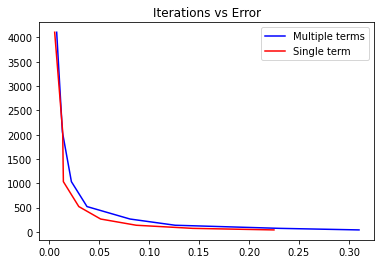

In [5]:
plt.title('Iterations vs Error')
plt.plot(errors, Ns, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

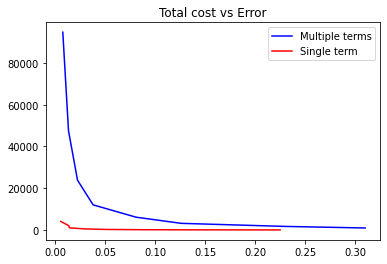

In [6]:
plt.title('Total cost vs Error')
plt.plot(errors, tcosts, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

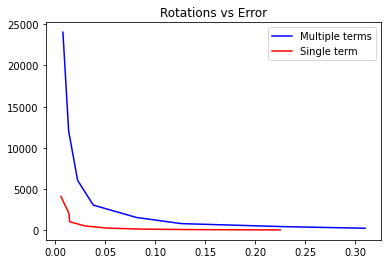

In [7]:
plt.title('Rotations vs Error')
plt.plot(errors, rcosts, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

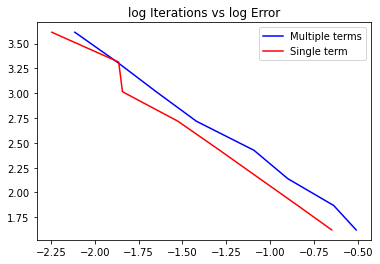

In [8]:
plt.title('log Iterations vs log Error')
plt.plot(np.log10(errors), np.log10(Ns), 'b-', label='Multiple terms', markersize=3)
plt.plot(np.log10(errors1), np.log10(Ns), 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

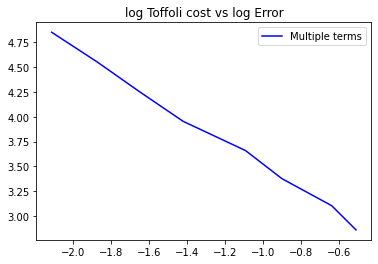

In [9]:
toffcost = tcosts - rcosts

plt.title('log Toffoli cost vs log Error')
plt.plot(np.log10(errors), np.log10(toffcost), 'b-', label='Multiple terms', markersize=3)
plt.legend()
plt.show()

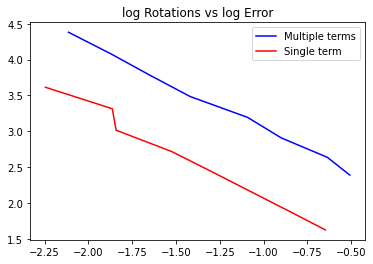

In [10]:
plt.title('log Rotations vs log Error')
plt.plot(np.log10(errors), np.log10(rcosts), 'b-', label='Multiple terms', markersize=3)
plt.plot(np.log10(errors1), np.log10(Ns), 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

In [11]:
print(errors1[-1], errors[-1])

0.005691056107318097 0.007702824173048771


In [12]:
# np.savetxt('rcosts', rcosts)
# np.savetxt('tcosts', tcosts)
# np.savetxt('errors', errors)
# np.savetxt('errors1', errors1)
# np.savetxt('Ns', Ns)